# Amazon Forecast PoC for E-Commerce workload


이 문서는 MLOps pipeline 구성에 앞서, 데이터 전처리 요구사항 및 적절한 Forecast Hyper Parameter등을 확인하기 위한 PoC 과정을 설명합니다.


AWS official Github repository인 [amazon-forecast-samples](https://github.com/aws-samples/amazon-forecast-samples)의 [Getting_started_with_AutoML.ipynb](https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Getting_started_with_AutoML/Getting_started_with_AutoML.ipynb)를 기반으로 작성하였습니다.



## Setup <a class="anchor" id="setup"></a>

필요한 Python 라이브러리 준비합니다.

In [1]:
import sys
import os
import time
import json

import boto3

import pandas as pd
import matplotlib.pyplot as plt

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("common") )
import util
from datetime import datetime, timedelta

가공된 데이터를 보관할 S3 bucket명과 실습할 리전을 설정합니다.

앞서 생성한 S3 bucket 명으로 수정합니다.

In [2]:
bucketName = "forecast-bucket-joozero" # Please put your s3 bucket name
assert bucketName, "bucket_name not set."

region = "ap-northeast-2" # Please edit here
assert region, "region not set."

download_prefix="raw_data/"
upload_prefix="poc/"
local_prefix="data/"

아래의 명령어를 통해 Notebook instance에 파일을 다운로드 및 업로드할 폴더를 생성합니다.

In [3]:
download_path=local_prefix+download_prefix
upload_path=local_prefix+upload_prefix

try:
    os.mkdir(download_path)
    os.mkdir(upload_path)
except OSError as err:
    print("OS error: {0}".format(err))
else:
    print("Successfully created the two directories %s and %s" % (download_path, upload_path))

Successfully created the two directories data/raw_data/ and data/poc/


AWS Python SDK인 boto3를 이용해 사용될 AWS 서비스를 선언합니다.

In [4]:
session = boto3.Session(region_name=region) 

forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

s3 = session.client('s3')

## 데이터 전처리
    

### CSV 원본 데이터 다운로드 및 확인

Rawdata는 s3://`"your_bucketName"`/raw_data/ 상에 단일 csv 파일로 존재합니다.

간단한 데이터 탐색 및 전처리를 위해 Notebook instance에 다운로드합니다.


In [5]:
keys=s3.list_objects(Bucket=bucketName,Prefix=download_prefix)['Contents']
files=[]
file_name=""

for key in keys:
    if not (key.get('Key').endswith('/')):
        file_name=key['Key'].split("/")[-1]
        s3.download_file(Filename=local_prefix+download_prefix+file_name, Bucket=bucketName, Key=key['Key'])
        files.append(local_prefix+download_prefix+file_name)

In [6]:
df = pd.read_csv(local_prefix+download_prefix+file_name, index_col=0)

df.index.name='timestamp'
df.head(10)


,item_id,target_value
timestamp,,
2018/01/01,item1,518
2018/01/02,item1,159
2018/01/03,item1,155
2018/01/04,item1,172
2018/01/05,item1,182
2018/01/06,item1,169
2018/01/07,item1,148
2018/01/08,item1,433
2018/01/09,item1,156


### 데이터 전처리 및 S3 업로드

rawdata를 Forecast가 지원하는 포맷에 맞도록 간단한 전처리를 수행합니다. 

이 예제에서는 간단히 timestamp format(yyyy/MM/dd -> yyyy-MM-dd)을 변경합니다. 

#### 참고 : Forecast가 지원하는 타임스탬프 형식
> 참조 : https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/dataset-import-guidelines-troubleshooting.html
- Forecast는 수집 빈도 단위가 년(Y), 월(M), 주(W) 및 <u>일(D)일 경우 yyyy-MM-dd</u> 타임스탬프 형식(예: 2019-08-21)을, 그리고 선택 사항으로 HH:mm:ss 형식(예: 2019-08-21 15:00:00)을 지원합니다.
- 수집 빈도 단위가 시간(H) 및 분(M)일 경우에는 Forecast가 yyyy-MM-dd HH:mm:ss 형식(예: 2019-08-21 15:00:00)만 지원합니다.

In [7]:
df.index=pd.to_datetime(df.index)
df.head(10)

,item_id,target_value
timestamp,,
2018-01-01,item1,518
2018-01-02,item1,159
2018-01-03,item1,155
2018-01-04,item1,172
2018-01-05,item1,182
2018-01-06,item1,169
2018-01-07,item1,148
2018-01-08,item1,433
2018-01-09,item1,156


### 데이터 탐색 

실습에 사용할 데이터는 **2018-01-01 부터 2019-12-31**까지의 **2500개**의 가상의 상품에 대한 **일간** 데이터 입니다.

데이터는 다양한 수요 패턴을 포함하고 있으며, 그중 아래 예시 데이터를 중심으로 Forecast의 예측 결과를 확인 해보겠습니다.

- 첫번째 데이터(item1)는 주 2일 간 높은 판매량(예, 주말)을 보이는 상품에 대한 예측입니다.
- 두번째 데이터(item2001)는 특정 범위에서 꾸준한 판매량을 보이는 스테디셀러 상품에 대한 예측입니다.

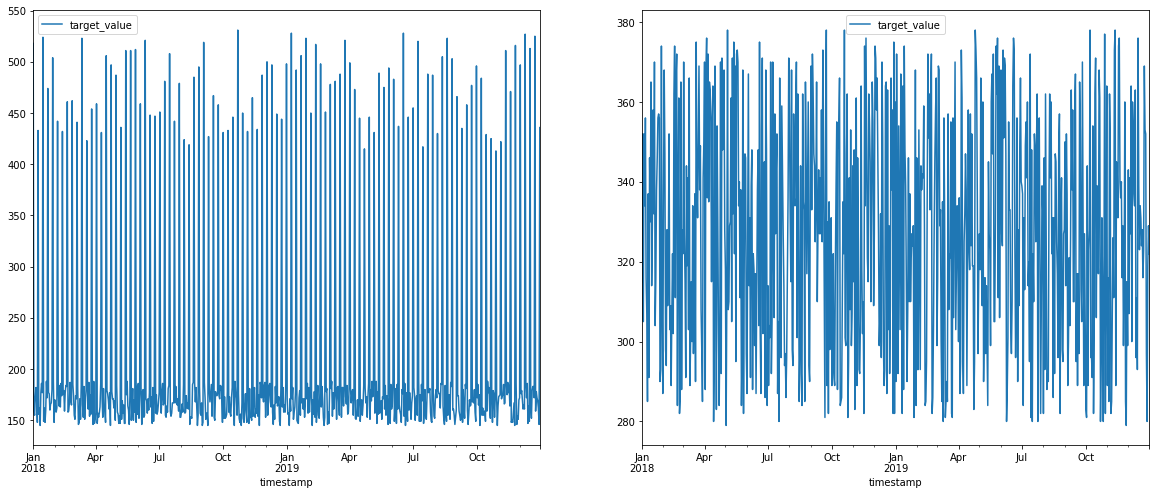

In [8]:
fig, axs = plt.subplots(1,2)

df[df.item_id=='item1'].plot(figsize=(20,8), ax=axs[0])
df[df.item_id=='item2001'].plot(figsize=(20,8), ax=axs[1])


### S3 업로드
전처리가 끝난 파일을 S3상에 업로드 합니다.

이후 Notebook instance에서 Forecast 작업을 하기 위한 IAM Role을 확인합니다.

In [9]:
df.to_csv(local_prefix+upload_prefix+file_name,header=False)
s3.upload_file(local_prefix+upload_prefix+file_name, bucketName, upload_prefix+file_name)

In [10]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-AutoML"
role_arn = util.get_or_create_iam_role( role_name = role_name )

The role ForecastNotebookRole-AutoML exists, ignore to create it
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


## Amazon Forecast 구성
### Create Dataset

앞서 생성한 Rawdata를 Forecast에 가지고 오기 위해서는 **Dataset**과 **Dataset Group**이 먼저 정의되어야합니다.
이때 각각 데이터의 카테고리와 형태를 의미하는 "도메인"과 "스키마"를 정의해주어야 합니다.


범용적으로 사용할 수 있는 [CUSTOM](https://docs.aws.amazon.com/forecast/latest/dg/custom-domain.html) 도메인이나, 오늘 사용할, 리테일 수요 예측에 필요한 데이터 셋을 정의한 [RETAIL](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/retail-domain.html) 도메인 처럼,

도메인 선택에 따라 미리 정의된 필수/선택 컬럼들 명이 달라지게 되니 자세한 내용은 [개발자 문서](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html)를 참조하기 바랍니다.

> `RETAIL` 도메인의 경우 필수 데이터 셋인 **대상 시계열 데이터**에 `timestamp`, `demand` and `item_id` 필드가 반드시 들어가야 합니다.


In [11]:
# 원본데이터가 Daily이므로 Frequency는 "D"

DATASET_FREQUENCY = "D" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [12]:
project = 'forecast_for_ecommerce_poc' # Replace this with a unique name here, make sure the entire name is < 30 characters.
datasetName= project+'_ds'
datasetGroupName= project +'_gp'
s3DataPath = "s3://"+bucketName+"/"+upload_prefix+file_name

In [13]:
datasetName

'forecast_for_ecommerce_poc_ds'

### 스키마 정의
입력 데이터인 CSV파일의 각 컬럼과 선택한 도메인이 요구하는 필수/선택적 데이터 매핑을 위한 스키마를 정의합니다.

- 스키마 정의 시 Attributes는 반드시 실제 CSV 컬럼 순서에 맞추어야 합니다.
- 데이터 인식의 기준은 CSV header가 아닌 스키마의 순서이므로 CSV에는 header가 없는 것이 좋습니다.

In [14]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      }
   ]
}

response=forecast.create_dataset(
                    Domain="RETAIL",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
                   )
datasetArn = response['DatasetArn']

In [15]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="RETAIL",
                                                              DatasetArns= [datasetArn]
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [16]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_for_ecommerce_poc_gp',
 'DatasetGroupArn': 'arn:aws:forecast:ap-northeast-2:794784903840:dataset-group/forecast_for_ecommerce_poc_gp',
 'DatasetArns': ['arn:aws:forecast:ap-northeast-2:794784903840:dataset/forecast_for_ecommerce_poc_ds'],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 9, 9, 12, 44, 16, 142000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 9, 9, 12, 44, 16, 142000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '22d9ebd8-370d-4a94-a075-5e179785304c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 09 Sep 2020 12:44:16 GMT',
   'x-amzn-requestid': '22d9ebd8-370d-4a94-a075-5e179785304c',
   'content-length': '370',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create Data Import Job
이제 S3상에 rawdata를 Amazon Forecast로 가지고 올 준비가 끝났습니다.

`create_dataset_import_job` API를 수행하여 S3경로 내 CSV 파일을 가지고 옵니다.

In [17]:
datasetImportJobName = 'POC_IMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [18]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:ap-northeast-2:794784903840:dataset-import-job/forecast_for_ecommerce_poc_ds/POC_IMPORT_JOB_TARGET


Data Import가 모두 완료될 때까지 기다립니다. 생성 과정 중에 **CREATE_IN_PROGRESS...**이 표시되며, 완료되면 **ACTIVE**가 출력됩니다. 
> 데이터의 크기에 따라, **ACTIVE** 상태가 되기까지 10분 정도 걸릴 수 있습니다. 


In [19]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(5)

status_indicator.end()

CREATE_PENDING ..
CREATE_IN_PROGRESS ........................................................................................
ACTIVE 


In [20]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'POC_IMPORT_JOB_TARGET',
 'DatasetImportJobArn': 'arn:aws:forecast:ap-northeast-2:794784903840:dataset-import-job/forecast_for_ecommerce_poc_ds/POC_IMPORT_JOB_TARGET',
 'DatasetArn': 'arn:aws:forecast:ap-northeast-2:794784903840:dataset/forecast_for_ecommerce_poc_ds',
 'TimestampFormat': 'yyyy-MM-dd',
 'DataSource': {'S3Config': {'Path': 's3://forecast-bucket-joozero/poc/forecast_data.csv',
   'RoleArn': 'arn:aws:iam::794784903840:role/ForecastNotebookRole-AutoML'}},
 'FieldStatistics': {'demand': {'Count': 1825000,
   'CountDistinct': 996,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0.0',
   'Max': '995.0',
   'Avg': 211.31687342465753,
   'Stddev': 221.89389136757669},
  'item_id': {'Count': 1825000, 'CountDistinct': 2500, 'CountNull': 0},
  'timestamp': {'Count': 1825000,
   'CountDistinct': 730,
   'CountNull': 0,
   'Min': '2018-01-01T00:00:00Z',
   'Max': '2019-12-31T00:00:00Z'}},
 'DataSize': 0.039302644319832325,
 'Status': 'ACTIVE',
 'CreationTime'

### 예측기(Predictor) 생성

#### 예상 빈도, 구간의 설정
**Forecast horizon**은 우리가 예측하게 될 시점(시간 단계)들의 개수를 의미하며, 이는 예상 빈도(**Forecast Frequency**)에 따라 의미하는 바가 달라집니다.

- 일간 예측을 선택한 경우, 다시말해 **Forecast Frequency**가 'D'로 설정된 경우, **Forecast horizon**를 60로 설정하면 60일 약 두 달의 예측을 가능한 모델이 생성됩니다.

참고로 Forecast Frequency는 Dataset 생성 시 설정한 Data Frequency보다 같거나 큰 단위만 설정할 수 있습니다.

- 가령 일간 데이터 셋에 대해 월간 예측을 설정할수 있으며 이 경우 예측 값을 합산하여 보여주며, 
- 일간 데이터로 시간 단위의 예측은 불가능합니다.

이 외의 예측기 생성 시 사용하는 파라미터의 의미는 개발자 문서 내 [예측기](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/howitworks-predictor.html) 페이지를 참조하시기 바랍니다

#### 알고리즘 선택
이 실습에서는 실습 시간 관계 상 AutoML이 아닌 CNN-QR 알고리즘을 선택하여 학습을 진행합니다.

어떤 알고리즘을 선택해야 할지 모르신다면, [아래 페이지](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-choosing-recipes.html)를 참고하시거나 PerformAutoML 옵션을 사용하십시오. 
> `AlgorithmArn="arn:aws:forecast:::algorithm/CNN-QR",` 부분을 제거하고
> `PerformAutoML=False,` 을 `PerformAutoML=True,` 로 변경하면 됩니다.

In [21]:
predictorName = project+'_cnn_predictor'

In [22]:
forecastHorizon = 60

In [23]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
#                                                    AlgorithmArn="arn:aws:forecast:::algorithm/Deep_AR_Plus",
                                                    AlgorithmArn="arn:aws:forecast:::algorithm/CNN-QR",                                                                                                        
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": 60}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "D", 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "demand", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

In [24]:
predictorArn=create_predictor_response['PredictorArn']

Predictor 생성이 완료될 때까지 기다립니다. 생성 과정 중에 **CREATE_IN_PROGRESS...**이 표시되며, 완료되면 **ACTIVE**가 출력됩니다. 
> 데이터의 크기나 모델과 하이퍼파라미터 선택에 따라 **ACTIVE** 상태가 되기까지 10분에서 1시간 이상까지 걸릴 수 있습니다. 


In [ ]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_predictor(PredictorArn=predictorArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(5)

status_indicator.end()

CREATE_PENDING ...
CREATE_IN_PROGRESS ..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 


### 예측기의 성능 확인

예측기를 생성한 후에는 [GetAccuracyMetrics](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/API_GetAccuracyMetrics.html) API를 이용하여 생성된 Forecast의 정확성을 평가할 수 있습니다.

Amazon Forecast은 [백테스트(backtesting)](https://en.wikipedia.org/wiki/Backtesting)를 사용하여 지표를 생성합니다.

이를 위해 Forecast는 다음 그림과 같이 입력 데이터를 교육 데이터 세트와 테스트 데이터 세트로 자동으로 분리합니다. 

![Backtesting](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/images/evaluation-offset.png)

이를 이용하여 평균 제곱근 오차(RMSE), 가중 분위 손실(wQuantileLoss)등을 계산하며, 이것이 성능의 지표가 됩니다. 
자세한 내용은 [예측기 정확성 평가](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/metrics.html)문서를 참고하시기 바랍니다.

AutoML은 이용하는 경우, 여러 알고리즘을 학습해보고 그중 가중 분위 손실(P10, P50, P90)의 평균을 최적화하여 가장 낮은 값의 알고리즘을 반환합니다.
(`GetAccuracyMetrics` API를 이용하여 Winning Argorithm을 확인할 수 있습니다.)


In [ ]:
forecast.get_accuracy_metrics(PredictorArn=predictorArn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/CNN-QR',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 22.239767501125844,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.028026123910631442},
       {'Quantile': 0.5, 'LossValue': 0.06331338681569221},
       {'Quantile': 0.1, 'LossValue': 0.025397958900457773}]}},
    {'TestWindowStart': datetime.datetime(2019, 11, 2, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2020, 1, 1, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 2500,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 22.23976750112586,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.02802612391063145},
       {'Quantile': 0.5, 'LossValue': 0.06331338681569221},
       {'Quantile': 0.1, 'LossValue': 0.02539795890045777}]}}]}],
 'ResponseMetadata': {'RequestId': '016c5421-0cf5-48e6-9523-e84989413bbd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'

### Create Forecast

이제 앞서 생성한 모델을 이용하여 아이템 들에 대한 예측을 생성합니다.

In [ ]:
forecastName= project+'_cnn_forecast'

In [ ]:
create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictorArn)
forecastArn = create_forecast_response['ForecastArn']

Forecast 생성이 완료될 때까지 기다립니다. 생성 과정 중에 **CREATE_IN_PROGRESS...**이 표시되며, 완료되면 **ACTIVE**가 출력됩니다. 
> 데이터의 크기나 모델과 하이퍼파라미터 선택에 따라 **ACTIVE** 상태가 되기까지 10분에서 1시간 이상까지 걸릴 수 있습니다. 

In [ ]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast(ForecastArn=forecastArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

### Get Forecast

Predictor를 기반으로 Forecast가 생성되면 대상 item_id를 기준으로 예상치를 확인할 수 있습니다.

아래는 예측값을 과거값과 통합하여 보여주기 위한 시각화용 함수를 정의합니다.

In [36]:
def plot_forecasts(target_account,forecastResponse,time_back = 120):
    df_target=df[df.item_id==target_account].reset_index();

    p10 = pd.DataFrame(forecastResponse['Forecast']['Predictions']['p10'])
    p50 = pd.DataFrame(forecastResponse['Forecast']['Predictions']['p50'])
    p90 = pd.DataFrame(forecastResponse['Forecast']['Predictions']['p90'])
    df_predict= pd.merge(pd.merge(p10, p50, on= 'Timestamp'),p90, on= 'Timestamp')

    pred_int = p50['Timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))
    p10.Timestamp = p10['Timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))
    p90.Timestamp = p90['Timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))

    fcst_start_date = pred_int.iloc[0]
    fcst_end_date = pred_int.iloc[-1]

    time_int = df_target['timestamp']

    plt.figure(figsize=(20, 10))
    plt.plot(time_int[-time_back:],df_target['target_value'].values[-time_back:], color = 'r' )
    plt.plot(pred_int, p50['Value'].values, color = 'k')

    plt.fill_between(pred_int, 
                     p10['Value'].values,
                     p90['Value'].values,
                     color='b', alpha=0.3);
    plt.axvline(x=pd.Timestamp(fcst_start_date), linewidth=3, color='g', ls='dashed')
    plt.axvline(x=pd.Timestamp(fcst_end_date), linewidth=3, color='g', ls='dashed')
    plt.xticks(rotation=30)
    plt.legend(['Target', 'Forecast'], loc = 'lower left')

단일 아이템에 대한 예측값이 필요한 경우 `query_forecast` API를 이용합니다.

첫번째 데이터(item1)는 주 2일 간 높은 판매량(예, 주말)을 보이는 상품에 대한 예측입니다.

예측 그래프에서 검은색은 P50을 영역의 최하단은 P10, 최상단은 P90을 의미합니다.

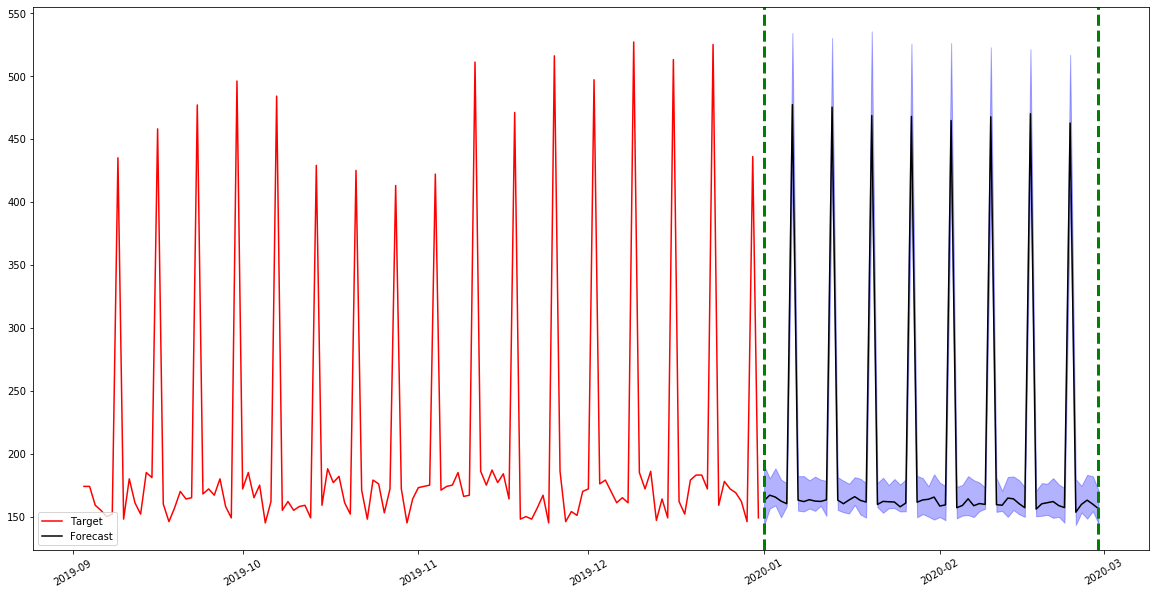

In [37]:
target_account='item1'

forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
   Filters={"item_id":target_account}
)
plot_forecasts(target_account,forecastResponse,time_back = 120)
#print(forecastResponse)

다음 예(item2001)는 특정 범위에서 꾸준한 판매량을 보이는 스테디셀러 상품에 대한 예측입니다.

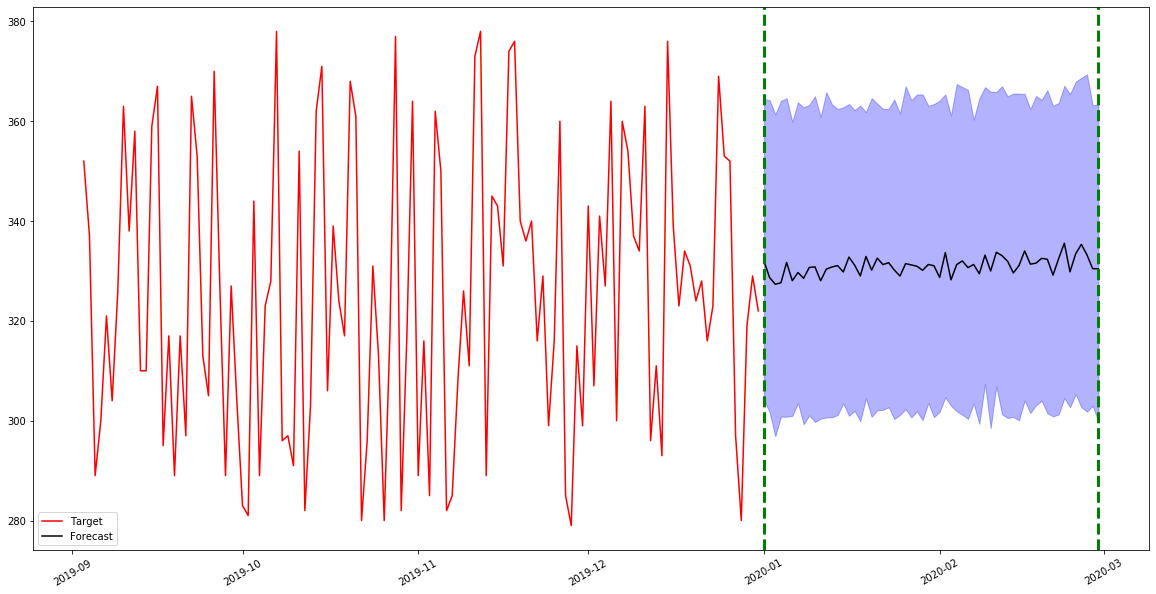

In [38]:
target_account='item2001'

forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
   Filters={"item_id":target_account}
)
plot_forecasts(target_account,forecastResponse,time_back = 120)
#print(forecastResponse)

# Export Forecast (Optional)

매번 API 호출을 통해 단일 Item에 대한 결과 값을 확인할 수도 있지만
전체 Forecast 결과를 S3 bucket에 CSV 파일 형태로 내보내어 활용할 수도 있습니다. 

이 경우 S3에 대한 접근권한이 있는 IAM Role이 필요합니다. (이전 단계에 이미 생성하였습니다.)

In [39]:
forecastExportName= project+'_aml_forecast_export'

In [40]:
outputPath="s3://"+bucketName+"/output"

In [44]:
forecast_export_response = forecast.create_forecast_export_job(
                                                                ForecastExportJobName = forecastExportName,
                                                                ForecastArn=forecastArn, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath,
                                                                       "RoleArn": role_arn
                                                                   } 
                                                                }
                                                              )

In [45]:
forecastExportJobArn = forecast_export_response['ForecastExportJobArn']

In [46]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast_export_job(ForecastExportJobArn=forecastExportJobArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_IN_PROGRESS ...........
ACTIVE 


S3 bucket에 생성된 결과를 확인합니다.

In [47]:
#s3.list_objects(Bucket=bucketName,Prefix="output")

# 리소스 정리

모든 실습을 완료하였으면 리소스를 정리합니다. `delete_iam_role`를 제외하고는 모든 과정은 비동기(asynchronous)로 이루어 지기때문에 완전히 완료될 때까지 기다린 후에 노트북을 종료하시기 바랍니다.


In [48]:
# Delete forecast export for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecastExportJobArn))

Successful delete


In [49]:
# Delete forecast
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecastArn))

Successful delete


In [51]:
# Delete predictor
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictorArn))

Successful delete


In [52]:
# Delete Import
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn))

Successful delete


In [53]:
# Delete the dataset
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=datasetArn))

Successful delete


In [54]:
# Delete Dataset Group
util.wait_till_delete(lambda: forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn))

Successful delete


In [55]:
# Delete IAM role
util.delete_iam_role( role_name )